# Spanning Groups: Building Relationships From Contextual Data

In today's data-driven world, it is becoming increasingly important to extract useful insights and knowledge from large amounts of data. One area where this is particularly relevant is in the analysis of textual data, where the challenge is to extract meaningful relationships and insights from unstructured text.

In this project, we explore the use of spanning trees to build relationships from contextual data for the companies listed in the S&P 500. First, we retrieve the constituents of the S&P 500 and their corresponding descriptions from Wikipedia. Secondly, we use Sentence Transformers to create sentence embeddings for each company description, and finally, we build a spanning tree from these sentence embeddings using Kruskal's algorithm, which allows us to identify relationships and clusters among the S&P 500 companies.

Through this project, we demonstrate how spanning groups can be a powerful tool for building relationships from contextual data. The resulting spanning tree provides a unique perspective on the relationships and similarities among the S&P 500 companies, which can be useful for a wide range of applications out of finance, like marketing and business strategy.

---
This project is based on the following blog post:

[Building a S&P 500 company classification from Wikipedia articles (guided by ChatGPT)](https://marti.ai/quant/2023/05/07/wikipedia-network-companies-sentence-transformers.html)


In [1]:
# libs
import os
import re
import time
import pickle
import math as mt
import numpy as np
import pandas as pd
from tqdm import tqdm
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data
compDF = pd.read_pickle('data/external/sp500_companies.pkl')
embDF = pd.read_pickle('data/processed/comp_embeddings.pkl')

## Section 1: Getting Data from Wikipedia for S&P 500 Companies

The S&P 500 is a stock market index that tracks the performance of 500 large-cap companies listed on the New York Stock Exchange (NYSE) or NASDAQ. It is widely regarded as one of the best indicators of the performance of the U.S. stock market and is commonly used as a benchmark for the overall health of the economy.

The companies listed in the S&P 500 span a wide range of industries, including technology, healthcare, finance, consumer goods, and energy. Some of the most well-known companies in the index include Apple, Amazon, Microsoft, Facebook, JPMorgan Chase, and Exxon Mobil.

The S&P 500 index consists of a diverse range of companies from various industries, making it challenging to identify meaningful relationships and clusters among them. However, the use of spanning trees provides an alternative approach to identifying underlying relationships and similarities among these companies based on their textual descriptions. Additionally, spanning trees can complement the GICS classification system by identifying connections between companies from different sectors that share similar characteristics or operate in related markets.

In [3]:
compDF[['symbol','security','gics_sector','description_']].head()

,symbol,security,gics_sector,description_
0,MMM,3M,Industrials,3M (originally the Minnesota Mining and Manufa...
1,AOS,A. O. Smith,Industrials,A. O. Smith Corporation is an American manufac...
2,ABT,Abbott,Health Care,Abbott Laboratories is an American multination...
3,ABBV,AbbVie,Health Care,AbbVie Inc. is a pharmaceutical company headqu...
4,ACN,Accenture,Information Technology,Accenture plc is an Irish-American professiona...


## Section 2: Using Sentence Transformers to Create Sentence Embeddings for Each Company

Sentence embeddings are a type of vector representation of sentences that capture the meaning and context of the words in a sentence. These embeddings are used in many natural language processing (NLP) tasks, such as text classification, sentiment analysis, information retrieval, and question-answering. Sentence embeddings, encode the meaning and context of the entire sentence, and they can be used to compare and match sentences based on their semantic similarity.

There are various methods to create sentence embeddings, such as averaging word embeddings, using convolutional or recurrent neural networks, or using pre-trained language models. These methods can generate high-quality sentence embeddings that capture the semantic and syntactic structure of the sentences.

In [4]:
# sentence embeddings for each company in the S&P 500, data has already been processed in a separate script to avoid time consuming processes
embDF.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
MMM,-0.108703,0.650491,-0.212877,0.192672,0.816147,-0.113679,0.290792,0.170104,0.004452,0.048294,...,-0.114466,-0.239219,-0.263429,0.206075,-0.499930,0.634846,0.058329,0.030066,-0.196537,-0.490986
AOS,0.170608,0.171758,-0.001843,0.290108,0.783179,-0.424888,0.400951,-1.384314,-0.324195,0.289884,...,-0.044909,0.035526,-0.077688,1.059140,0.175373,0.806471,0.208044,0.041334,-0.739792,-0.676073
ABT,-0.024590,0.458317,-0.249453,-0.524105,0.435759,-0.503350,0.412072,-1.080753,0.169008,-0.293726,...,0.911794,0.316633,-0.280175,0.316101,-0.011377,0.184839,0.937722,0.466070,0.118955,-0.682608
ABBV,0.115734,0.380234,-0.476213,0.054778,0.679103,-0.636217,0.411154,-0.437119,-0.024681,-0.061885,...,0.489085,0.071161,-0.427124,0.638283,-0.369893,-0.067552,0.025587,0.604850,-0.043197,-0.459766
ACN,0.576570,0.616734,-0.177062,-0.866646,0.490072,-0.872510,0.663430,0.136533,0.459790,0.853222,...,-0.757985,-1.169704,-0.438475,0.303590,-0.155075,0.659655,0.069850,-0.119685,-0.447991,-0.741178


## Section 3: Building a Spanning Tree

In graph theory, a spanning tree is a subset of a connected undirected graph that connects all the vertices without forming any cycles. A spanning tree can be obtained by removing some edges from the original graph, while ensuring that the resulting graph remains connected.

Spanning trees have various applications in graph theory, such as in **network design**, routing algorithms, and optimization problems. In particular, spanning trees can be used to find the shortest path between two nodes in a graph or to determine the minimum cost of connecting all the nodes in a network.

In [5]:
# angular distance as distance matrix
embd_dist = np.sqrt(0.5*(1-embDF.T.corr()))

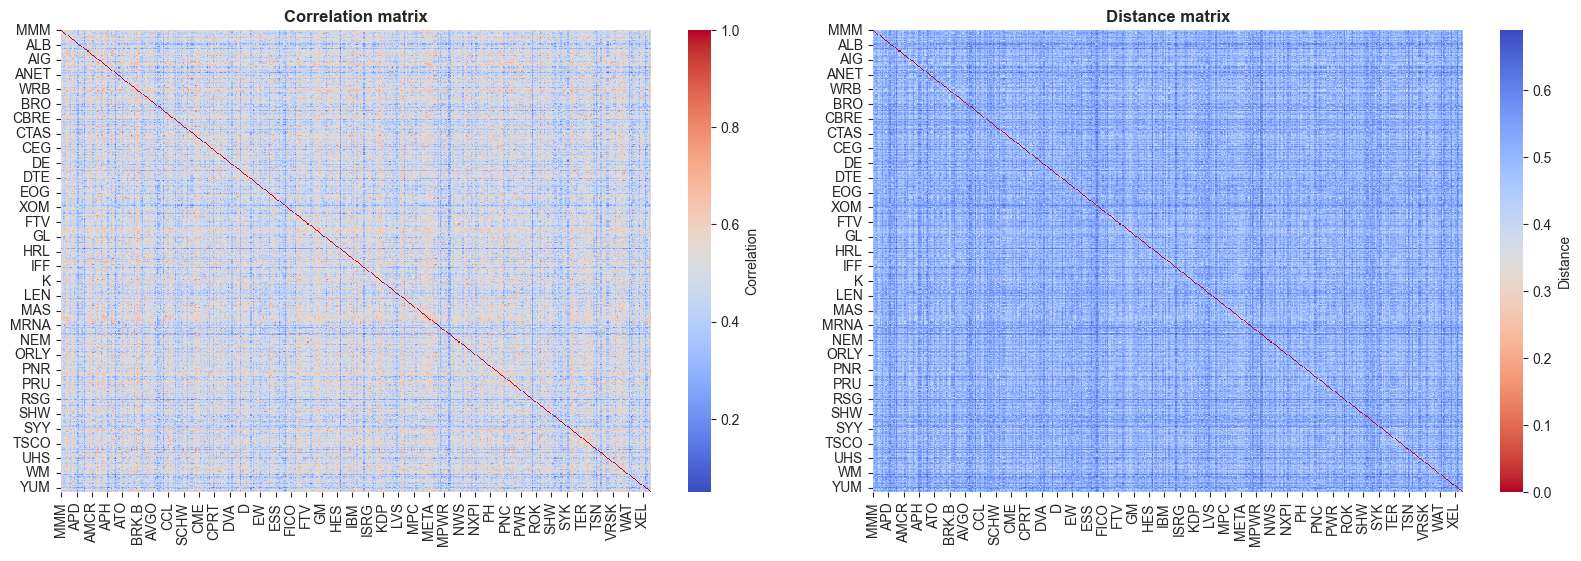

In [6]:
sns.set_style("ticks")
sns.set_palette("colorblind")

# Create a figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(20, 6))

# Plot the first heatmap in the left subplot
sns.heatmap(embDF.T.corr(), ax=axs[0], cmap="coolwarm", cbar_kws={"label": "Correlation"})
axs[0].set_title("Correlation matrix", fontweight="bold")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

# Plot the second heatmap in the right subplot
sns.heatmap(embd_dist, ax=axs[1], cmap="coolwarm_r", cbar_kws={"label": "Distance"})
axs[1].set_title("Distance matrix", fontweight="bold")
axs[1].set_xlabel("")
axs[1].set_ylabel("")

# Add the legend to the figure
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False)

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.1)

In [7]:
# compute the minimum spanning tree for all the companies
graph = nx.from_numpy_array(embd_dist.values)
mst = nx.minimum_spanning_tree(graph)

# custom labels
custom_labels = {i: embd_dist.columns[i] for i in range(embd_dist.shape[0])}

In [8]:
# get the closest nodes up to second degree of proximity from 'NVDA'
comp = 'NVDA'
idx_node = np.where(embd_dist.index == comp)[0][0]
closest_nodes = {}
for distance in range(1, 4):
    shortest_paths = nx.shortest_path_length(mst, source=idx_node)
    nodes_at_distance = [node for node, path_length in shortest_paths.items() if path_length == distance]
    closest_nodes[distance] = nodes_at_distance

# print the closest nodes up to second degree of proximity
for distance, nodes in closest_nodes.items():
    node_names = [custom_labels[node] for node in nodes]
    print(f"Nodes at distance {distance}: {node_names}")

Nodes at distance 1: ['ZBRA', 'AMD', 'ADSK', 'AKAM']
Nodes at distance 2: ['PTC', 'ADBE', 'ANSS', 'APTV', 'AXON', 'INTC']
Nodes at distance 3: ['WDC', 'MSI', 'EA', 'JNPR', 'CDNS', 'IBM', 'STX', 'MU']


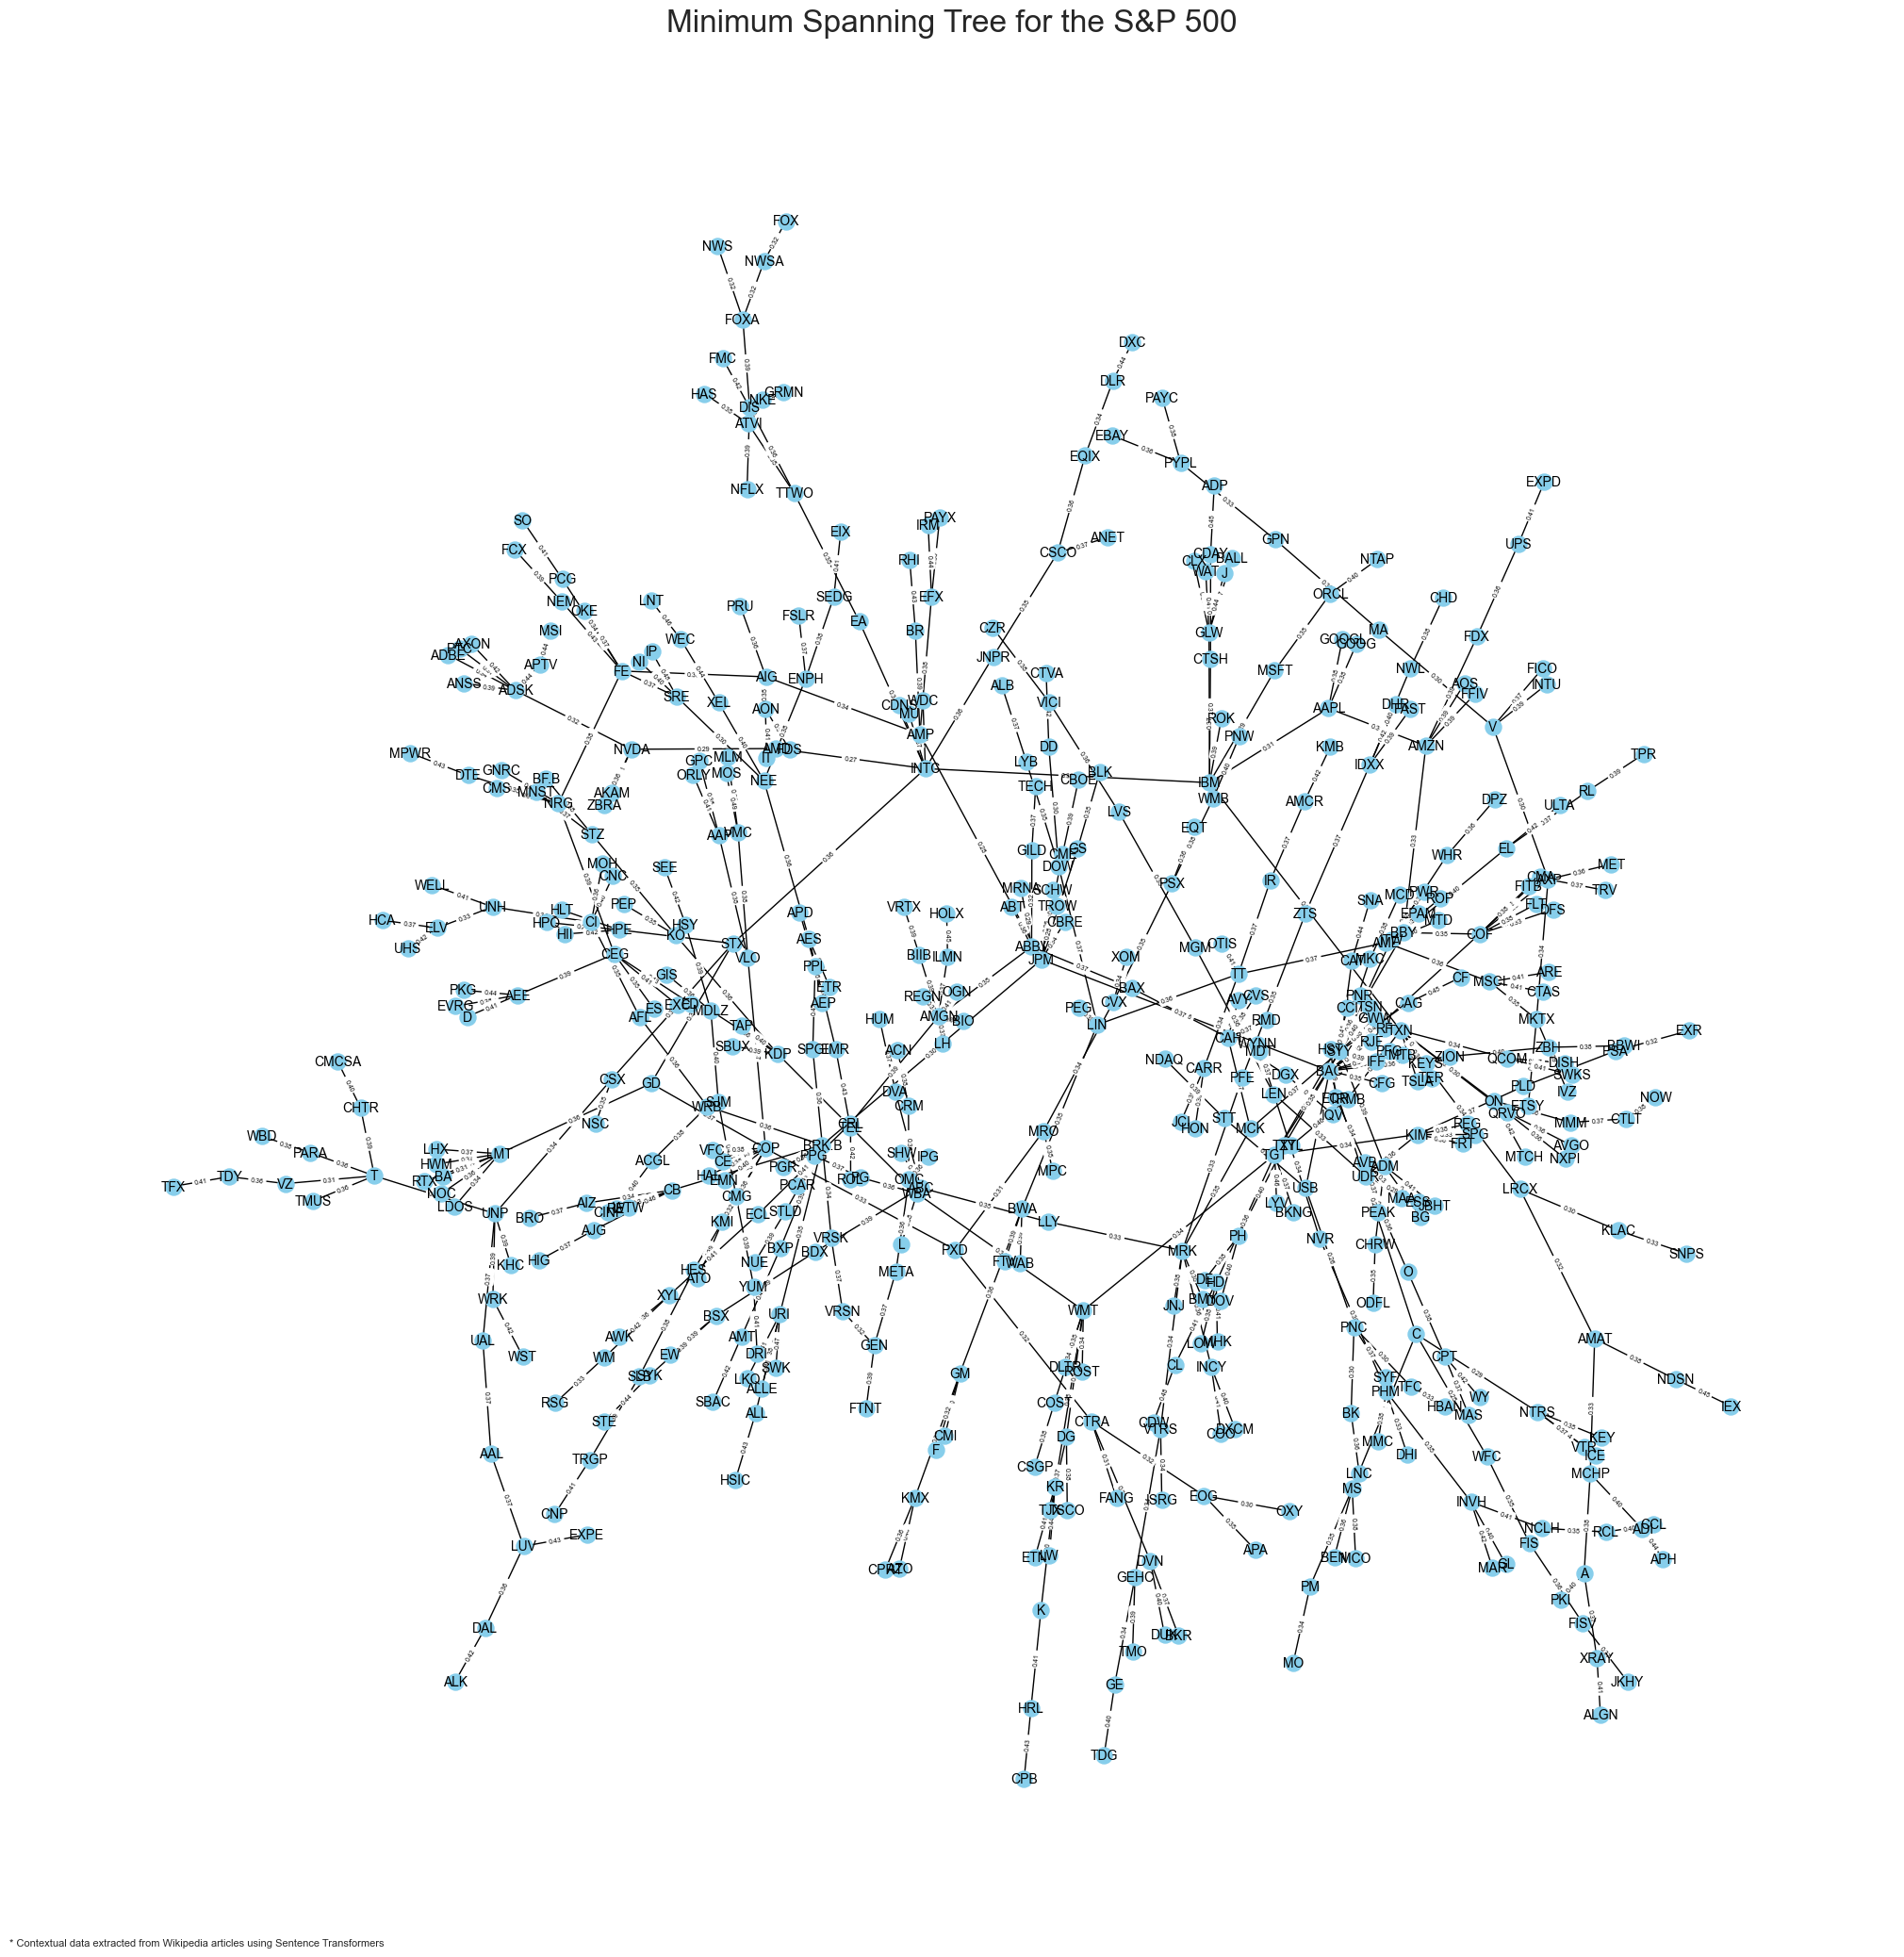

In [9]:
# Visualize the minimum spanning tree
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(mst, seed=42)

nx.draw(mst, pos, labels=custom_labels, with_labels=True, node_color="skyblue", font_size=10, node_size=150)
nx.draw_networkx_edge_labels(mst, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in mst.edges(data=True)}, font_size=5)

# Add the subtitle
plt.title("Minimum Spanning Tree for the S&P 500", loc='center', fontsize=24, pad=20)
plt.text(0, 0, "* Contextual data extracted from Wikipedia articles using Sentence Transformers", fontsize=8, ha='left', va='center', transform=plt.gca().transAxes)

plt.show()